# Explore Decoupled Intelligence

The proposal/hypothesis is here https://docs.google.com/document/d/1x7n2iy1_LZXZNLQpxCzF84lZ8BEG6ZT3KWXC59erhJA

This notebook investigates the **Structural Separation** hypothesis:
- Models contain distinct circuits for prompt categorization and response generation
- Categorization circuits are invariant to specific numeric inputs

In [1]:
# CatGen (singleton) config class
class CG:
    # Model we are testing.
    #MODEL_NAME = "chatgpt2" # Public model.
    #MODEL_NAME = "EleutherAI/gpt-j-6B"   # Public model. Runs on CoLab Pro with A100 GPU
    #MODEL_NAME = "EleutherAI/gpt-neox-20b" # Public model. Runs on CoLab Pro with A100 GPU
    #MODEL_NAME = "llama-30b"
    #MODEL_NAME = "llama-65b"
    #MODEL_NAME = "gpt2-xl"
    MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct" # Gated Model. Need HF_TOKEN secret. Request access via https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.

    # Default layer we expect to the model to use as the 'Categorization Layer'
    MODEL_LAYER = 8

    # Number of mathematical tasks we test: Max, Min, Avg, Sum, Diff, Prod
    NUM_TASKS = 6

    # We run each task using 5 times - using a different pair of numbers each time
    NUMBER_EXAMPLES = 6

    MAX_NEW_TOKENS = 20

    IN_COLAB = False

## Step 1: Import Libraries

In [2]:
!pip install transformer-lens accelerate

In [3]:
import sys
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from transformers import GPTJForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA
from huggingface_hub import login

In [4]:
try:
    import google.colab
    from google.colab import userdata
    CG.IN_COLAB = True
except:
    CG.IN_COLAB = False

In [5]:
if CG.IN_COLAB:
    !pip install --upgrade git+https://github.com/PhilipQuirke/LlmPromptCategorization.git -q
else:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import MathsCatGen as mcg

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.4 MB/s eta 0:00:00


## Step 2: Load open-source model

In [6]:
# Retrieve the token from Colab Secrets
hf_token = userdata.get('HF_TOKEN')

# Log into Hugging Face Hub
login(hf_token)

In [7]:

#model = HookedTransformer.from_pretrained(
model = HookedTransformer.from_pretrained_no_processing( # Preferred with reduced precision
    model_name=CG.MODEL_NAME,
    device="cuda" if torch.cuda.is_available() else "cpu",
    dtype="float16",              # A100 handles float16 well
    fold_ln=True,
    center_writing_weights=True,
    center_unembed=True)
    #tokenizer_pad_token=None,
    #n_devices=1 )                  # Change to >1 if sharded across GPUs

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer


## Step 3: Define Tasks
We use the core math tasks that share identical phrasing up until the final task-identifying word .

In [8]:
tasks = ['min', 'max', 'avg', 'sum', 'diff', 'prod']

# Prompt structure uses few-shot examples to improve model answer conciseness
few_shot_prefix = "Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ:"

test_data = [
    {"prompt": f"{few_shot_prefix} Minimum of 21 and 39", "task": "min", "gt": "21", "x":"21", "y":"39"},
    {"prompt": f"{few_shot_prefix} Least of 11 & 23", "task": "min", "gt": "11", "x":"11", "y":"23"},
    {"prompt": f"{few_shot_prefix} Min of 65 and 49", "task": "min", "gt": "49", "x":"65", "y":"49"},
    {"prompt": f"{few_shot_prefix} Which is lesser 32 or 11?", "task": "min", "gt": "11", "x":"32", "y":"11"},
    {"prompt": f"{few_shot_prefix} Which is less 19 or 12?", "task": "min", "gt": "12", "x":"19", "y":"12"},
    {"prompt": f"{few_shot_prefix} Given 17 and 23 what is the littler", "task": "min", "gt": "17", "x":"17", "y":"23"},

    {"prompt": f"{few_shot_prefix} For 13 and 3 return the maximum", "task": "max", "gt": "13", "x":"13", "y":"3"},
    {"prompt": f"{few_shot_prefix} Given 15 & 13 which is the largest", "task": "max", "gt": "15", "x":"15", "y":"13"},
    {"prompt": f"{few_shot_prefix} Bigger of 22 and 36", "task": "max", "gt": "36", "x":"22", "y":"36"},
    {"prompt": f"{few_shot_prefix} Which of 48 or 32 is larger?", "task": "max", "gt": "48", "x":"48", "y":"32"},
    {"prompt": f"{few_shot_prefix} What is max of 19 and 12?", "task": "max", "gt": "19", "x":"19", "y":"12"},
    {"prompt": f"{few_shot_prefix} Given 18 and 12 what is biggest", "task": "max", "gt": "18", "x":"18", "y":"12"},

    {"prompt": f"{few_shot_prefix} Given 25 and 9 what is the average", "task": "avg", "gt": "17", "x":"25", "y":"9"},
    {"prompt": f"{few_shot_prefix} Given 14 & 4 what is the avg", "task": "avg", "gt": "9", "x":"14", "y":"4"},
    {"prompt": f"{few_shot_prefix} Mean of 11 and 47", "task": "avg", "gt": "29", "x":"11", "y":"47"},
    {"prompt": f"{few_shot_prefix} What is average of 54 and 12?", "task": "avg", "gt": "33", "x":"54", "y":"12"},
    {"prompt": f"{few_shot_prefix} What is mean of 9 & 13?", "task": "avg", "gt": "11", "x":"9", "y":"13"},
    {"prompt": f"{few_shot_prefix} Given 8 and 22 what is the average", "task": "avg", "gt": "15", "x":"8", "y":"22"},

    {"prompt": f"{few_shot_prefix} Given 25 and 9 what is the sum", "task": "sum", "gt": "34", "x":"25", "y":"9"},
    {"prompt": f"{few_shot_prefix} Given 14 & 3 what is the total", "task": "sum", "gt": "17", "x":"14", "y":"3"},
    {"prompt": f"{few_shot_prefix} Add 12 and 47", "task": "sum", "gt": "59", "x":"12", "y":"47"},
    {"prompt": f"{few_shot_prefix} What is 55 plus 12?", "task": "sum", "gt": "67", "x":"55", "y":"12"},
    {"prompt": f"{few_shot_prefix} What is 9 + 13?", "task": "sum", "gt": "22", "x":"9", "y":"13"},
    {"prompt": f"{few_shot_prefix} Given 8 and 22 what is the sum", "task": "sum", "gt": "30", "x":"8", "y":"22"},

    {"prompt": f"{few_shot_prefix} Given 15 and 9 what is the difference", "task": "diff", "gt": "6", "x":"15", "y":"9"},
    {"prompt": f"{few_shot_prefix} Given 14 & 3 what is the diff", "task": "diff", "gt": "11", "x":"14", "y":"3"},
    {"prompt": f"{few_shot_prefix} Difference beween 12 and 40", "task": "diff", "gt": "28", "x":"12", "y":"40"},
    {"prompt": f"{few_shot_prefix} What is 55 minus 12?", "task": "diff", "gt": "43", "x":"55", "y":"12"},
    {"prompt": f"{few_shot_prefix} What is 19 less 13?", "task": "diff", "gt": "6", "x":"19", "y":"13"},
    {"prompt": f"{few_shot_prefix} Given 8 and 22 what is the diff", "task": "diff", "gt": "14", "x":"8", "y":"22"},

    {"prompt": f"{few_shot_prefix} Given 5 and 9 what is the product", "task": "prod", "gt": "45", "x":"15", "y":"9"},
    {"prompt": f"{few_shot_prefix} Given 14 & 3, multiple them", "task": "prod", "gt": "42", "x":"14", "y":"3"},
    {"prompt": f"{few_shot_prefix} Product of 12 and 40", "task": "prod", "gt": "480", "x":"12", "y":"40"},
    {"prompt": f"{few_shot_prefix} Multiple 55 by 13?", "task": "prod", "gt": "715", "x":"55", "y":"13"},
    {"prompt": f"{few_shot_prefix} Product of 19 and 3?", "task": "prod", "gt": "57", "x":"19", "y":"11"},
    {"prompt": f"{few_shot_prefix} Given 8 and 22 calculate the product", "task": "prod", "gt": "176", "x":"8", "y":"22"},
]

In [9]:
assert len(tasks) == CG.NUM_TASKS
assert len(test_data) == CG.NUM_TASKS * CG.NUMBER_EXAMPLES
for d in test_data:
    assert d['task'] in tasks

In [10]:
# Generate the prompt list using the new test_data structure
all_prompts = []
metadata = []

# Iterate directly over the new test_data list of dictionaries
for item in test_data:
    prompt = item['prompt']
    task = item['task']
    x_val = item['x']
    y_val = item['y']
    gt = item['gt'] # Ground truth

    all_prompts.append(prompt)
    metadata.append({"task": task, "pair": f"({x_val},{y_val})", "gt": gt})

print(all_prompts[0:5])
print(metadata[0:5])

['Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ: Minimum of 21 and 39', 'Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ: Least of 11 & 23', 'Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ: Min of 65 and 49', 'Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ: Which is lesser 32 or 11?', 'Q: What is 5+5? A: 10\nQ: What is 2+2 A: 4\nQ: Which is less 19 or 12?']
[{'task': 'min', 'pair': '(21,39)', 'gt': '21'}, {'task': 'min', 'pair': '(11,23)', 'gt': '11'}, {'task': 'min', 'pair': '(65,49)', 'gt': '49'}, {'task': 'min', 'pair': '(32,11)', 'gt': '11'}, {'task': 'min', 'pair': '(19,12)', 'gt': '12'}]


## Step 4. Check Baseline Accuracy
If model can't answer the above prompts correctly, then it may not have categorization or generation circuits for the task concepts, making investigation useless.

In [11]:
def evaluate_model(data):
  results = []
  for i, d in enumerate(data):
    # Generate output
    output = model.generate(d["prompt"], max_new_tokens=CG.MAX_NEW_TOKENS+10, stop_at_eos=True, verbose=False)

    # Simple parsing to check if the ground truth is in the generated text
    clean_output = output.replace(d["prompt"], "").strip()
    is_correct = mcg.is_ground_truth_correct(clean_output, d["gt"])

    results.append({"prompt": d["prompt"][-35:], "output": clean_output[:25], "correct": bool(is_correct)})

  accuracy_df = pd.DataFrame(results)
  correct_answers_count = accuracy_df['correct'].sum()
  total_answers_count = len(accuracy_df)

  print(f"Accuracy: {correct_answers_count} of {total_answers_count} = {correct_answers_count / total_answers_count * 100:.2f}%")

  return accuracy_df


print("Checking baseline accuracy...")
accuracy_df = evaluate_model(test_data)
pd.set_option('display.width', 100)
print(accuracy_df[['prompt', 'output', 'correct']])

Checking baseline accuracy...
Accuracy: 33 of 36 = 91.67%
                                  prompt                       output  correct
0   is 2+2 A: 4\nQ: Minimum of 21 and 39   : A: 21\nQ: What is 14-9 A     True
1   hat is 2+2 A: 4\nQ: Least of 11 & 23   A: 11\nQ: What is 7-3 A: 4     True
2   hat is 2+2 A: 4\nQ: Min of 65 and 49   is A: 49\nQ: The maximum o     True
3   2 A: 4\nQ: Which is lesser 32 or 11?  A: 11\nQ: odor of flowers\n     True
4   2+2 A: 4\nQ: Which is less 19 or 12?   A: 12\nQ: How many legs do     True
5    Given 17 and 23 what is the littler   number A: 17\nThe team has     True
6   \nQ: For 13 and 3 return the maximum   B: 13\nQ: Print the alphab     True
7     Given 15 & 13 which is the largest  number? A: 15\n\nQ: Given t     True
8    is 2+2 A: 4\nQ: Bigger of 22 and 36   ? A: 36\nQ: Why computer?      True
9   : 4\nQ: Which of 48 or 32 is larger?   A: 48\nQ: What is 3 x 3? B     True
10  2 A: 4\nQ: What is max of 19 and 12?   A: 19\nQ: What is minimum     

## Step 5: Layer-wise Separation Profile

Above we assumed the model categorized the prompt input by Layer 8. This was a guess. Here we evaluate the best layer to use.

Intra-task Similarity (Blue Line): This represents the "Stability" of the categorization. According to your Structural Separation hypothesis, this should rise sharply and stay high once the model has recognized the "intent" (e.g., "summing"), regardless of the numbers provided.

Inter-task Similarity (Red Line): This represents the "Ambiguity" between tasks. Ideally, this should remain low. If this line rises alongside the blue line, the model is seeing "mathematical intent" but failing to distinguish "sum" from "product."

The Gating Point: You are looking for the point where the Blue line is highest and the Red line is lowest.

In many models like GPT-NeoX or GPT-J, this typically occurs in the middle-to-late layers (e.g., layers 8–16 of 28).

If the lines diverge early, the Categorization Circuit is simple (likely just keyword detection).

If they only diverge at the very end, the categorization is deeply tied to the Generation Circuit.

Analyzing layer-wise separation profile...


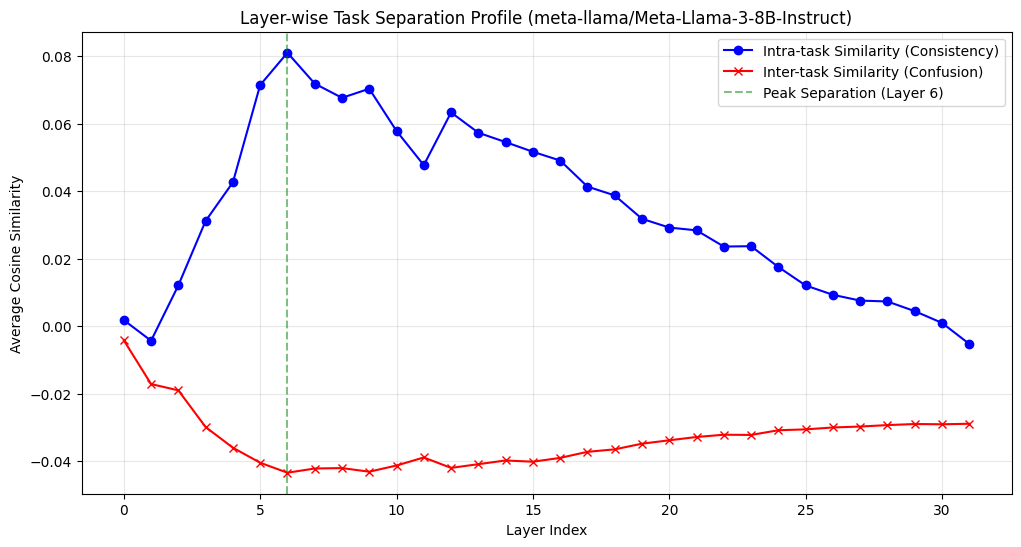

Analysis Complete. The highest separation between tasks was observed at Layer 6.


In [12]:
# Initialize storage for metrics
layer_indices = range(model.cfg.n_layers)
intra_task_sims = []
inter_task_sims = []

print("Analyzing layer-wise separation profile...")

# 1. Loop through all layers in the model
for layer_idx in layer_indices:
    layer_activations = []

    # Extract activations for all prompts at the current layer
    for prompt in all_prompts:
        with torch.no_grad():
            # Note: We use the same cache logic as Step 4 but iterate through layers
            _, cache = model.run_with_cache(prompt, names_filter=lambda name: name.endswith("resid_post"))
            vec = cache["resid_post", layer_idx][0, -1, :].detach().cpu()
            layer_activations.append(vec)

    # Convert list to tensor: [NUM_TASKS * NUMBER_EXAMPLES, d_model]
    layer_tensor = torch.stack(layer_activations)

    # Calculate Centroid-Subtracted (Task-Specific) Vectors for this layer
    layer_centroid = layer_tensor.mean(dim=0)
    layer_specific = layer_tensor - layer_centroid

    # Normalize for cosine similarity calculation
    norm_layer = F.normalize(layer_specific, p=2, dim=1)

    # Calculate the full similarity matrix [25, 25] for this layer
    sim_matrix = torch.mm(norm_layer, norm_layer.t())

    # 2. Calculate Intra-task similarity
    # How similar are different number pairs within the same task block (diagonal 5x5 blocks)?
    intra_sim_vals = []
    for t in range(CG.NUM_TASKS):
        start_idx = t * CG.NUMBER_EXAMPLES
        end_idx = start_idx + CG.NUMBER_EXAMPLES
        # Extract the 5x5 sub-matrix for this task
        block = sim_matrix[start_idx:end_idx, start_idx:end_idx]
        # Get values excluding the self-similarity diagonal (which is always 1.0)
        mask = ~torch.eye(CG.NUMBER_EXAMPLES, dtype=bool)
        intra_sim_vals.append(block[mask].mean())

    avg_intra_sim = torch.stack(intra_sim_vals).mean().item()
    intra_task_sims.append(avg_intra_sim)

    # 3. Calculate Inter-task similarity
    # How similar are different tasks to each other (off-diagonal regions)?
    all_pairs_mask = torch.ones_like(sim_matrix, dtype=bool)
    for t in range(CG.NUM_TASKS):
        start_idx = t * CG.NUMBER_EXAMPLES
        end_idx = start_idx + CG.NUMBER_EXAMPLES
        # Mask out the diagonal intra-task blocks
        all_pairs_mask[start_idx:end_idx, start_idx:end_idx] = False

    avg_inter_sim = sim_matrix[all_pairs_mask].mean().item()
    inter_task_sims.append(avg_inter_sim)

# 4. Visualization
plt.figure(figsize=(12, 6))
plt.plot(layer_indices, intra_task_sims, label='Intra-task Similarity (Consistency)', marker='o', color='blue')
plt.plot(layer_indices, inter_task_sims, label='Inter-task Similarity (Confusion)', marker='x', color='red')

# Identify the "Categorization Layer" (Maximum Gap)
gap = [intra - inter for intra, inter in zip(intra_task_sims, inter_task_sims)]
best_layer = gap.index(max(gap))
plt.axvline(x=best_layer, linestyle='--', color='green', alpha=0.5, label=f'Peak Separation (Layer {best_layer})')

plt.title(f"Layer-wise Task Separation Profile ({CG.MODEL_NAME})")
plt.xlabel("Layer Index")
plt.ylabel("Average Cosine Similarity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Analysis Complete. The highest separation between tasks was observed at Layer {best_layer}.")

In [13]:
CG.MODEL_LAYER = best_layer
print(f"Using Layer {CG.MODEL_LAYER} for categorization.")

Using Layer 6 for categorization.


## Step 6: Extract Residual Stream Activations
To isolate the "Categorization Layer", you should extract the activations from the residual stream at the final token position across all layers. The final token (the task word) is where the categorization is finalized.

In [14]:
model_prompt_act = []
model_answers = []

for prompt in all_prompts:
    with torch.no_grad():
        # Extract activations for the categorization layer analysis using run_with_cache
        logits_for_activations, cache = model.run_with_cache(prompt)
        vec = cache["resid_post", CG.MODEL_LAYER][0, -1, :].detach().cpu()
        model_prompt_act.append(vec)

        # Generate a sequence of tokens for the model's answer
        input_ids = model.tokenizer.encode(prompt, return_tensors='pt').to(model.cfg.device)
        # Generate up to 10 new tokens for the answer. Using do_sample=False for deterministic output.
        generated_output_ids = model.generate(
            input_ids,
            max_new_tokens=10, # Allow up to 10 new tokens to cover ~35 characters
            do_sample=False,   # For deterministic answers for mathematical tasks
            temperature=0.0    # Set temperature to 0.0 for greedy decoding
            # Removed pad_token_id as it's not accepted by HookedTransformer.generate() for this model
        )

        # Decode only the newly generated part of the output
        generated_answer_tokens = generated_output_ids[0, len(input_ids[0]):]
        predicted_answer = model.tokenizer.decode(generated_answer_tokens, skip_special_tokens=True).strip()
        model_answers.append(predicted_answer)

model_prompt_tensor = torch.stack(model_prompt_act)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
print(model_answers[0:5])

['A: 21\nQ: Maximum of', 'A: 11\nQ: What is', 'A: 49\nQ: Max of', 'A: 11\nQ: What is', 'A: 12\nQ: What is']


## Step 7: Disentangling Categorization from Data

We subtract the average prompt "template" to find the task-specific vectors

In [16]:
# Calculate global mean (centroid) to remove template bias
global_centroid = model_prompt_tensor.mean(dim=0)
task_specific_vectors = model_prompt_tensor - global_centroid

## Step 8: Visualization: Similarity Heatmap

A powerful way to visualize this disentanglement is to create a similarity heatmap of all prompts (NUM_TASKS × NUMBER_EXAMPLES)

Intra-Task Consistency: Each 6x6 block represents a task (e.g., all "sum" prompts).The 6x6 blocks on the heatmap diagonal show how similar "sum (25,9)" is to "sum (99,1)". High similarity here confirms the categorization circuit is ignoring numeric (input) noise.

Inter-Task Orthogonality: The dark regions between blocks represent the separation between tasks. Different activations for different tasks => clear categorization between tasks.

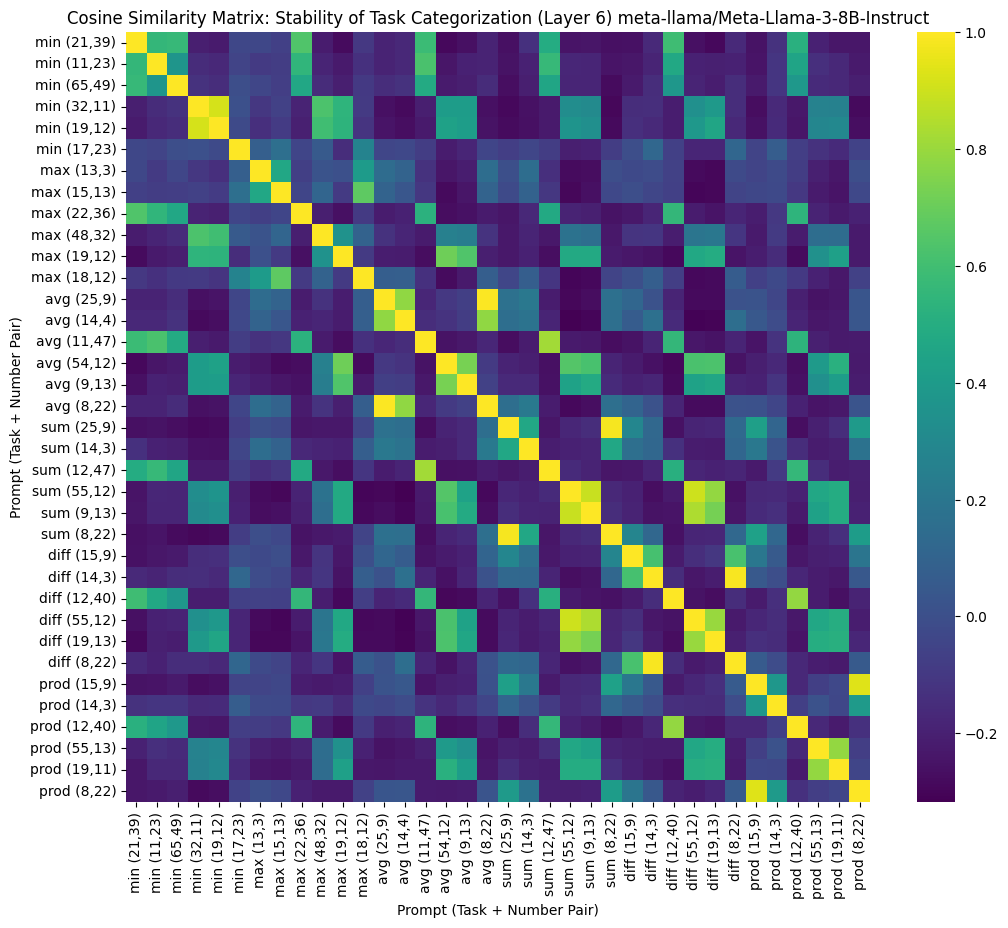

In [17]:
# Normalize for cosine similarity
norm_vecs = F.normalize(task_specific_vectors, p=2, dim=1)
sim_matrix = torch.mm(norm_vecs, norm_vecs.t()).numpy()

plt.figure(figsize=(12, 10))
labels = [f"{m['task']} {m['pair']}" for m in metadata]
sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels, cmap="viridis", annot=False)
plt.title(f"Cosine Similarity Matrix: Stability of Task Categorization (Layer {CG.MODEL_LAYER}) {CG.MODEL_NAME}")
plt.xlabel("Prompt (Task + Number Pair)")
plt.ylabel("Prompt (Task + Number Pair)")
plt.show()

## Step 9. Visualization: PCA Projection

We project the NUM_TASKS × NUMBER_EXAMPLES vectors into 2D space to see the "Task Clusters"

- If the "Structural Separation" hypothesis is true, these task clusters should be geometrically distant in the PCA plot. This is useful but weak evidence.

- Scale Coordination: You can observe if the clusters are roughly the same distance from the center, which would support the idea that the model uses a unified activation scale for all 100 tasks

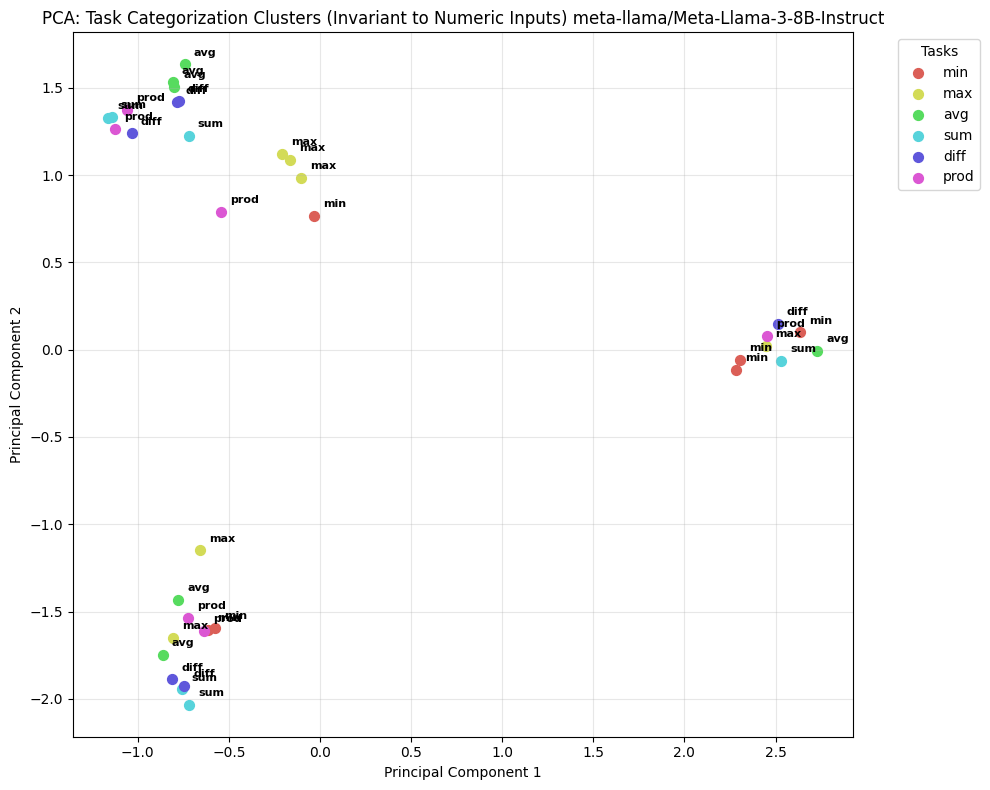

In [18]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(task_specific_vectors.numpy())

plt.figure(figsize=(10, 8))
colors = sns.color_palette("hls", len(tasks))
task_colors = {task: colors[i] for i, task in enumerate(tasks)}

# Create a scatter plot for each task group separately to ensure correct legend and colors
for task_name in tasks:
    # Get indices for current task
    task_indices = [i for i, m in enumerate(metadata) if m['task'] == task_name]

    # Plot points for this task
    plt.scatter(
        pca_results[task_indices, 0],
        pca_results[task_indices, 1],
        color=task_colors[task_name],
        label=task_name, # Each task gets one legend entry
        s=50 # default size for scatter points
    )

    # Add text labels for each point for direct identification
    for idx in task_indices:
        plt.text(
            pca_results[idx, 0] + 0.05,
            pca_results[idx, 1] + 0.05,
            metadata[idx]['task'], # Label with task name
            weight='bold',
            fontsize=8 # Smaller font size to reduce clutter
        )

plt.legend(title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside to prevent overlap
plt.title(f"PCA: Task Categorization Clusters (Invariant to Numeric Inputs) {CG.MODEL_NAME}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, alpha=0.3)
plt.tight_layout() # Adjust layout to prevent labels/legend from being cut off
plt.show()

## Step 10: Validation via Causal Intervention (Patching)

We run the model on an ambiguous prompt that doesn't specify 'sum' but add in the sum_vector. If the model gives the correct sum this is evidence that sum_vector is indeed the addition vector.

In [19]:
print("Test steering:")

ambiguous_prompt = f"{few_shot_prefix} Given 25 and 9 what is the color?"
print("  Prompt:", ambiguous_prompt.replace("\n"," "))

raw_output = model.generate(ambiguous_prompt, max_new_tokens=CG.MAX_NEW_TOKENS, stop_at_eos=True, verbose=False)
print("  Raw Output:", raw_output.replace(ambiguous_prompt, '').replace("\n"," ").strip())

def steering_hook(value, hook):
    # Add the sum_task_vector vector to steer the model toward addition logic
    return value + sum_task_vector.to(value.device)

with model.hooks(fwd_hooks=[(f"blocks.{CG.MODEL_LAYER}.hook_resid_post", steering_hook)]):
    steered_output = model.generate(ambiguous_prompt, max_new_tokens=10, verbose=False)
    print(f"  Steered Output: {steered_output.replace(ambiguous_prompt, '').replace("\n"," ").strip()}")

Test steering:
  Prompt: Q: What is 5+5? A: 10 Q: What is 2+2 A: 4 Q: Given 25 and 9 what is the color?
  Raw Output: A: Blue Q: What is the number that is the color 25+9? A


NameError: name 'sum_task_vector' is not defined